# Analysing climate change in Florida Northwest Region using pyspark

## Manoj Buddha

<a href="https://github.com/manojbuddha">Github</a> <a href="https://www.linkedin.com/in/manoj-buddha">Linkedin</a> <a href="https://manojbuddha.netlify.app/">Portfolio</a>

### Command to start docker container
Docker container should be running to connect to postgres database and store data.
```
docker run -p 5432:5432 --name dockerPostgres -v "c:/volDocker/postgres/var/lib/postgresql/data" -e POSTGRES_PASSWORD=mypostgres -d postgres:14.0
```

#### Please make sure that "FloridaWeather.parquet" dataset and jupyter notebook are on the same path

In [1]:
# connecting pyspark with spark
import findspark
findspark.init()

# importing sql functions
import pyspark.sql.functions as f

# other imports
import os
import matplotlib.pyplot as plt

In [2]:
# importing pyspark and checking for pyspark and spark connection
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession 
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(sc.version)
print(spark.version)

2.4.8
2.4.8


In [3]:
pwd

'C:\\BigData\\~notebookJupyter'

### Converting CSV data parquet using pyspark

In [4]:
# Directory data is present
dir = 'C:\BigData\Data'
# CSV file name
file_name = 'FloridaWeather.csv'
path = os.path.join(dir, file_name)
# reading csv dataset
weather_data = spark.read.option("sep", ",").option("header", "true").csv(path)
# name of destination parquet data
dest_file_name = 'FloridaWeather.parquet'
# writing csv data to parquet
weather_data.write.parquet(os.path.join(dir, dest_file_name))

### Functions to read and write data to and from postgres database

In [5]:
# Reading required table from postgres database, takes dataframe and table_name as input
def read_from_postgres(table_name):
    # table_name = "DailyWindSpeedTable"
    dataframe = spark.read \
        .format("jdbc") \
        .option("driver", "org.postgresql.Driver") \
        .option("url", "jdbc:postgresql://localhost:5432/WeatherData") \
        .option("dbtable", table_name) \
        .option("user", "postgres") \
        .option("password", "mypostgres") \
        .load()
    print("dataframe read from postgres completed")
    return dataframe
    
# writing data to postgres database, takes dataframe and table_name as input
def write_to_postgres(dataframe, table_name):
    
    dataframe.write \
        .format("jdbc") \
        .mode("overwrite") \
        .option("driver", "org.postgresql.Driver") \
        .option("url", "jdbc:postgresql://localhost:5432/WeatherData") \
        .option("dbtable", table_name) \
        .option("user", "postgres") \
        .option("password", "mypostgres") \
        .save()    
    print("data write to postgres completed")

In [6]:
# Create and use database
try:
    spark.sql("CREATE DATABASE WeatherData")
    spark.sql("USE WeatherData") 
except:
    print('Database already created!')
    spark.sql("USE WeatherData") 

In [7]:
# Reading data from parquet file
weather_data = spark.read.option("sep", ",").option("header", "true").parquet(os.path.join(dir, dest_file_name))

In [8]:
# Get the number of rows in a dataframe
print(f"Number of columns:{len(weather_data.columns)}\nNumber of rows: {weather_data.count()}")

Number of columns:108
Number of rows: 8888499


In [9]:
# getting the schema for the dataframe
weather_data.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- REPORT_TYPE2: string (nullable = true)
 |-- SOURCE3: string (nullable = true)
 |-- AWND: string (nullable = true)
 |-- CDSD: string (nullable = true)
 |-- CLDD: string (nullable = true)
 |-- DSNW: string (nullable = true)
 |-- DYHF: string (nullable = true)
 |-- DYTS: string (nullable = true)
 |-- DailyAverageDewPointTemperature: string (nullable = true)
 |-- DailyAverageDryBulbTemperature: string (nullable = true)
 |-- DailyAverageRelativeHumidity: string (nullable = true)
 |-- DailyAverageSeaLevelPressure: string (nullable = true)
 |-- DailyAverageStationPressure: string (nullable = true)
 |-- DailyAverageWetBulbTemperature: string (nullable = true)
 |-- DailyAverageWindSpeed: string (nullable = true)
 |-- DailyCoolingDegreeDays: string (nullable = true)
 |-- DailyDepartureFromNormalAverageTemperature: string (nullable = true)
 |-- DailyHeatingDegreeDays: string (nullable = true)
 |-- DailyMaximumDry

In [10]:
# function to get stat, it takes column name, stat (max, min, sum, avg, count), and year(optional) 
# as input and returns stat for the column by year
def get_column_stat(col_name, func, year=None):
    
    col_cleaned = weather_data.dropna(subset=[col_name])
    print(col_name)
    print(f"Number of rows after removing null {col_cleaned.count()}")

    # Extracting the year from the date
    col_cleaned = col_cleaned.withColumn('year', f.split('DATE', '-')[0])
    # Extracting the month from the date
    col_cleaned = col_cleaned.withColumn('month', f.split('DATE', '-')[1])

    # Getting only the required columns from the dataframe
    col_cleaned = col_cleaned.select(['DATE',col_name, 'year', 'month'])
    if year != None:
        col_cleaned = col_cleaned.filter(f.col('year')==year)
        grpby = 'month'
    else:
        grpby = 'year'
    # Converting col data to float
    col_cleaned = col_cleaned.withColumn(col_name, col_cleaned[col_name].cast('float'))
    
    if func.lower() == 'max':
        # Grouping by month to get maximum windspeed per month/year
        col_cleaned_grp = col_cleaned.groupBy(grpby).max(col_name)
        col_cleaned_grp = col_cleaned_grp \
            .withColumnRenamed(f"max({col_name})",f"Max {col_name}")
        
    if func.lower() == 'min':
        # Grouping by month to get minimum windspeed per month/year
        col_cleaned_grp = col_cleaned.groupBy(grpby).min(col_name)
        col_cleaned_grp = col_cleaned_grp \
            .withColumnRenamed(f"min({col_name})",f"Min {col_name}")
        
    if func.lower() == 'avg':
        # Grouping by month to get maximum windspeed per month/year
        col_cleaned_grp = col_cleaned.groupBy(grpby).avg(col_name)
        col_cleaned_grp = col_cleaned_grp \
            .withColumnRenamed(f"avg({col_name})",f"Average {col_name}")
        
    if func.lower() == 'sum':
        # Grouping by month to get maximum windspeed per month/year
        col_cleaned_grp = col_cleaned.groupBy(grpby).sum(col_name)
        col_cleaned_grp = col_cleaned_grp \
            .withColumnRenamed(f"sum({col_name})",f"Sum {col_name}")
        
    if func.lower() == 'count':
        # Grouping by month to get maximum windspeed per month/year
        col_cleaned_grp = col_cleaned.groupBy(grpby).count()
        col_cleaned_grp = col_cleaned_grp \
            .withColumnRenamed(f"count({col_name})",f"Count {col_name}")
    if year == None:
        return col_cleaned_grp.sort(col_cleaned_grp.year.asc())
    else:
        return col_cleaned_grp.sort(col_cleaned_grp.month.asc())    

In [11]:
get_column_stat('HourlyDryBulbTemperature', 'max').show()

HourlyDryBulbTemperature
Number of rows after removing null 8108464
+----+----------------------------+
|year|Max HourlyDryBulbTemperature|
+----+----------------------------+
|1938|                        92.0|
|1939|                        98.0|
|1940|                        95.0|
|1941|                        97.0|
|1942|                       101.0|
|1943|                       100.0|
|1944|                       103.0|
|1945|                        97.0|
|1946|                        96.0|
|1947|                       104.0|
|1948|                        98.0|
|1949|                        98.0|
|1950|                       101.0|
|1951|                       102.0|
|1952|                       104.0|
|1953|                       102.0|
|1954|                       104.0|
|1955|                        97.0|
|1956|                       102.0|
|1957|                        98.0|
+----+----------------------------+
only showing top 20 rows



In [12]:
get_column_stat('HourlyDryBulbTemperature', 'max', '2009').show()

HourlyDryBulbTemperature
Number of rows after removing null 8108464
+-----+----------------------------+
|month|Max HourlyDryBulbTemperature|
+-----+----------------------------+
|   01|                        79.0|
|   02|                        80.0|
|   03|                        85.0|
|   04|                        90.0|
|   05|                        94.0|
|   06|                       104.0|
|   07|                       104.0|
|   08|                       106.0|
|   09|                        94.0|
|   10|                        95.0|
|   11|                        81.0|
|   12|                        81.0|
+-----+----------------------------+



## Maximum 'DailyAverageWindSpeed' by year

In [13]:
tempdf = get_column_stat('DailyAverageWindSpeed', 'max')
print(type(tempdf))

# Writing the above spark dataframe to postgres database
write_to_postgres(tempdf, 'DailyAverageWindSpeed_max')

# Reading the 'HourlyDryBulbTemperature_max' table from postgres database
tempdf = read_from_postgres('DailyAverageWindSpeed_max')
tempdf = tempdf.sort(tempdf.year.asc())

DailyAverageWindSpeed
Number of rows after removing null 82394
<class 'pyspark.sql.dataframe.DataFrame'>
data write to postgres completed
dataframe read from postgres completed


Text(0, 0.5, 'year')

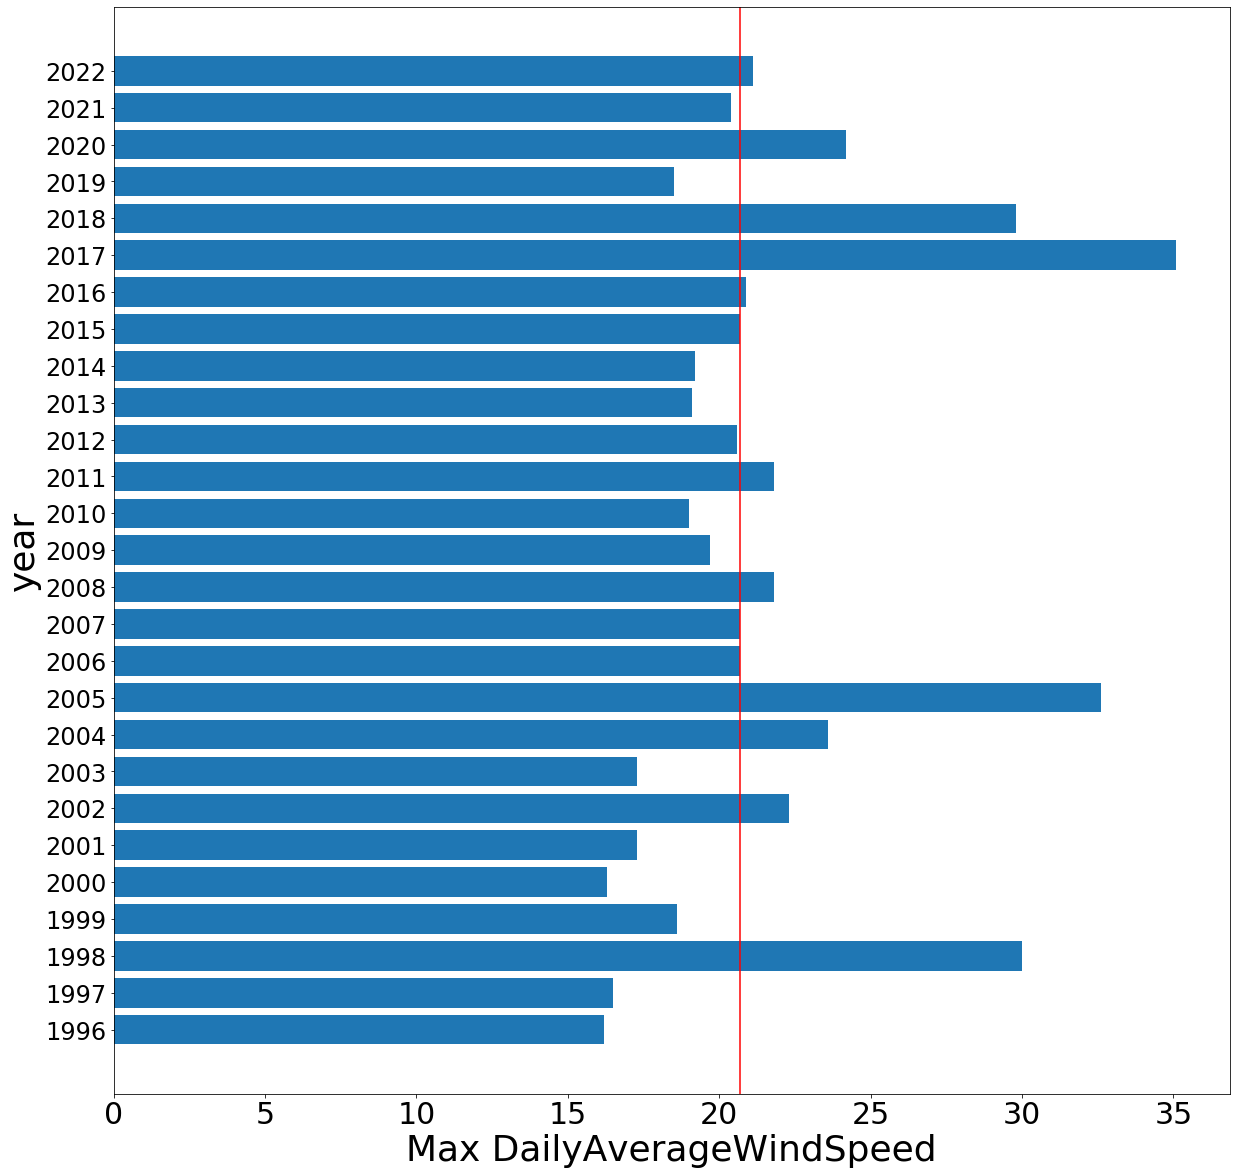

In [14]:
tempdf = tempdf.toPandas()

plt.figure(figsize=(20,20))
plt.barh(tempdf[tempdf.columns[0]], tempdf[tempdf.columns[1]])
plt.xticks(fontsize=30)
plt.yticks(fontsize=24)
plt.axvline(x = tempdf[tempdf.columns[1]].median(), color = 'r', linestyle = '-')
# plt.axvline(y = tempdf[tempdf.columns[1]].median(), color = 'r', linestyle = '-')
plt.xlabel(tempdf.columns[1], fontsize=36)
plt.ylabel(tempdf.columns[0], fontsize=36)

High wind speed can be attributed to hurricanes, and from above plot we can see a few spikes in the average wind speed 
for few years and if we dig deeper into the year 2017 which 
has the highest peak, we can see from figure 11 that in the 
year 2017 the DailyAverageWindSpeed was highest in the 
September, which can be attributed to hurricane Irma which hit the Tallahassee region on the 
10th of September.


## Maximum 'DailyAverageWindSpeed' by month for year 2017

In [15]:
tempdf = get_column_stat('DailyAverageWindSpeed', 'max', '2017')
print(type(tempdf))

# Writing the above spark dataframe to postgres database
write_to_postgres(tempdf, 'DailyAverageWindSpeed_max_2017')

# Reading the 'HourlyDryBulbTemperature_max' table from postgres database
tempdf = read_from_postgres('DailyAverageWindSpeed_max_2017')
tempdf = tempdf.sort(tempdf.month.asc())




DailyAverageWindSpeed
Number of rows after removing null 82394
<class 'pyspark.sql.dataframe.DataFrame'>
data write to postgres completed
dataframe read from postgres completed


Text(0, 0.5, 'Max DailyAverageWindSpeed')

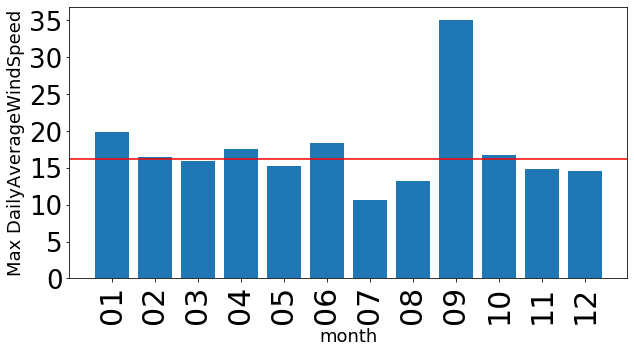

In [16]:
tempdf = tempdf.toPandas()

plt.figure(figsize=(10,5))
plt.bar(tempdf[tempdf.columns[0]], tempdf[tempdf.columns[1]])
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=26)
plt.axhline(y = tempdf[tempdf.columns[1]].median(), color = 'r', linestyle = '-')
plt.xlabel(tempdf.columns[0], fontsize=18)
plt.ylabel(tempdf.columns[1], fontsize=18)

## 'DailyPrecipitation' sum for each year

In [17]:
tempdf = get_column_stat('DailyPrecipitation', 'sum')
print(type(tempdf))

# Writing the above spark dataframe to postgres database
write_to_postgres(tempdf, 'DailyPrecipitation_sum')

# Reading the 'HourlyDryBulbTemperature_max' table from postgres database
tempdf = read_from_postgres('DailyPrecipitation_sum')
tempdf = tempdf.sort(tempdf.year.asc())


DailyPrecipitation
Number of rows after removing null 82531
<class 'pyspark.sql.dataframe.DataFrame'>
data write to postgres completed
dataframe read from postgres completed


Text(0, 0.5, 'Sum DailyPrecipitation')

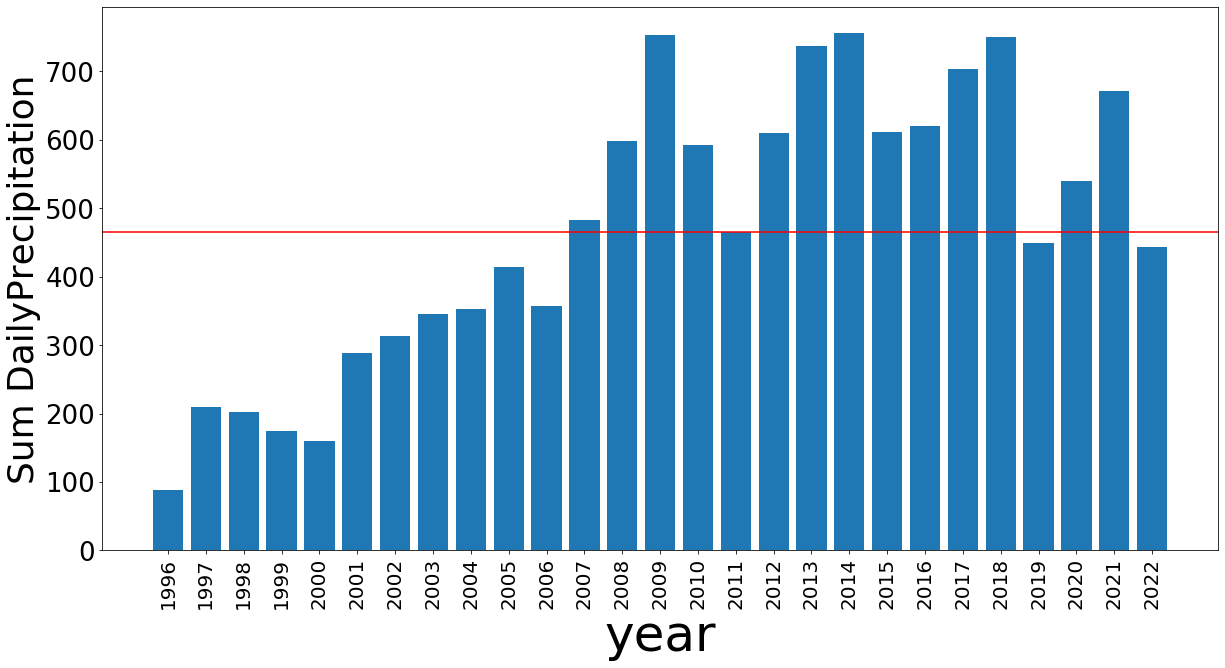

In [18]:
tempdf = tempdf.toPandas()

plt.figure(figsize=(20,10))
plt.bar(tempdf[tempdf.columns[0]], tempdf[tempdf.columns[1]])
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=26)
plt.axhline(y = tempdf[tempdf.columns[1]].median(), color = 'r', linestyle = '-')
plt.xlabel(tempdf.columns[0], fontsize=50)
plt.ylabel(tempdf.columns[1], fontsize=36)

## Maximum 'HourlyDryBulbTemperature' for each year
Note:- Dry-bulb temperature is commonly used as the standard air temperature reported

In [19]:
tempdf = get_column_stat('HourlyDryBulbTemperature', 'max')
print(type(tempdf))

# Writing the above spark dataframe to postgres database
write_to_postgres(tempdf, 'HourlyDryBulbTemperature_max')

# Reading the 'HourlyDryBulbTemperature_max' table from postgres database
tempdf = read_from_postgres('HourlyDryBulbTemperature_max')
tempdf = tempdf.sort(tempdf.year.asc())


HourlyDryBulbTemperature
Number of rows after removing null 8108464
<class 'pyspark.sql.dataframe.DataFrame'>
data write to postgres completed
dataframe read from postgres completed


Text(0, 0.5, 'year')

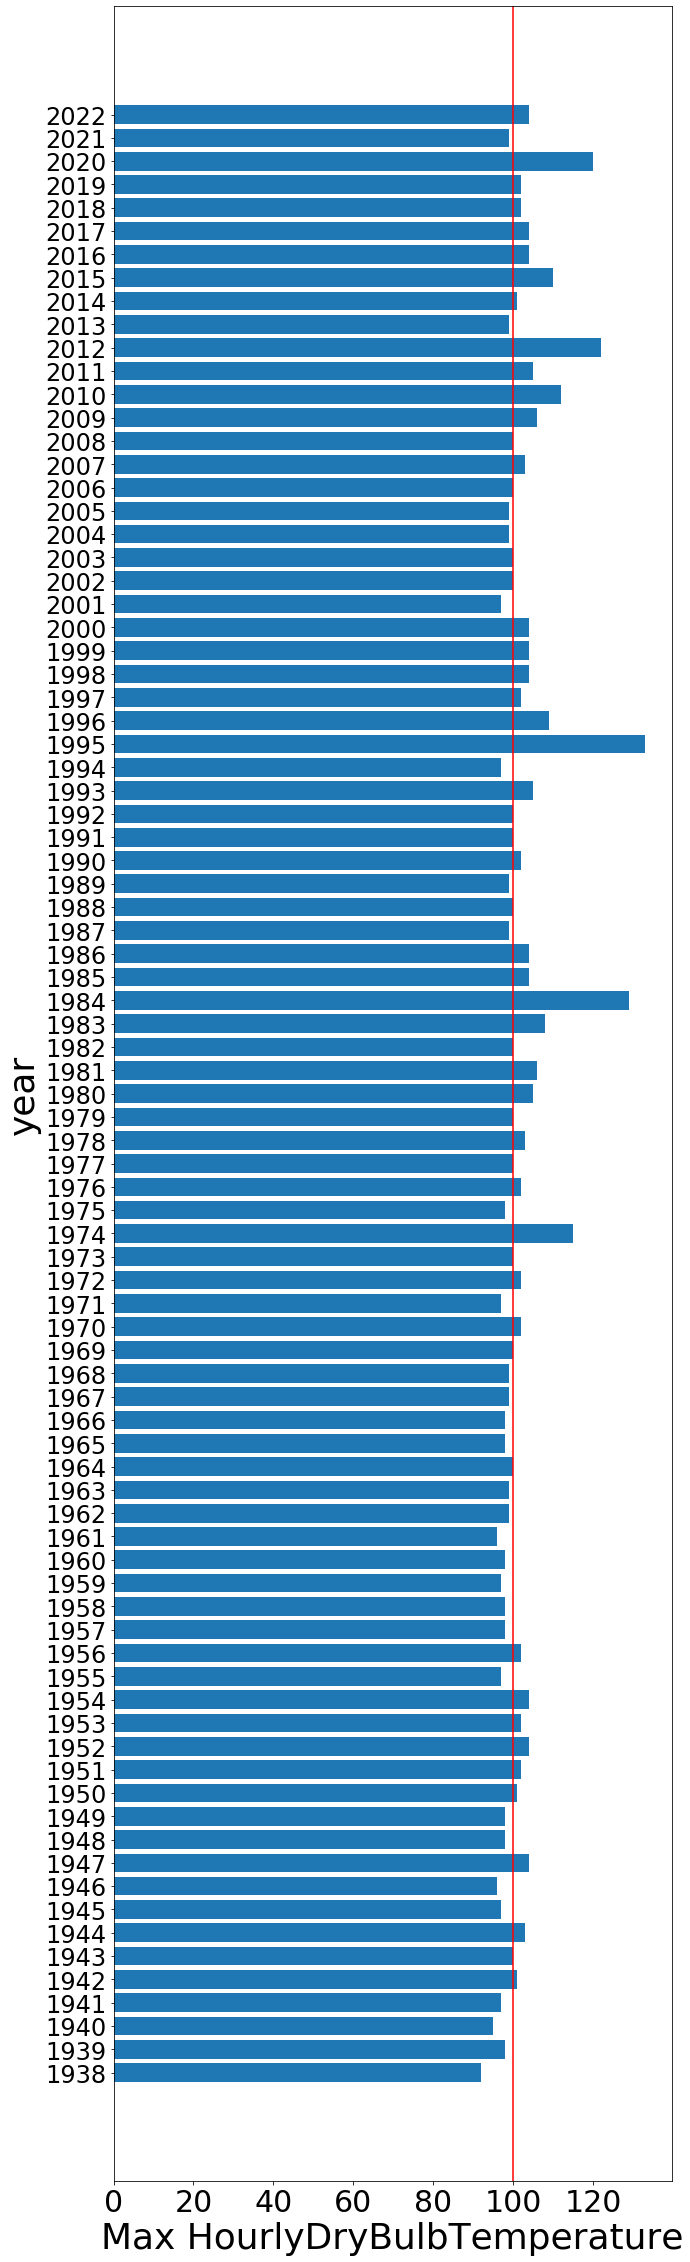

In [20]:
tempdf = tempdf.toPandas()

plt.figure(figsize=(10,40))
plt.barh(tempdf[tempdf.columns[0]], tempdf[tempdf.columns[1]])
plt.xticks(fontsize=30)
plt.yticks(fontsize=24)
plt.axvline(x = tempdf[tempdf.columns[1]].median(), color = 'r', linestyle = '-')
# plt.axvline(y = tempdf[tempdf.columns[1]].median(), color = 'r', linestyle = '-')
plt.xlabel(tempdf.columns[1], fontsize=36)
plt.ylabel(tempdf.columns[0], fontsize=36)

### The End